In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def aggregate_costs(df_costs: pd.DataFrame):
    group_columns = ["dataset", "algorithm", "k", "k_formatted", "coreset_size", "coreset_size_factor"]
    df_top_k = df_costs.groupby(group_columns, as_index=False).head(10)
    df_aggr_costs = df_top_k.groupby(group_columns, as_index=False).agg(
        experiment_count=("algorithm", "count"),
        real_cost_mean=("real_cost", "mean"),
        real_cost_std=("real_cost", "std"),
        coreset_cost_mean=("coreset_cost", "mean"),
        coreset_cost_std=("coreset_cost", "std"),
        running_time_mean=("running_time", "mean"),
        running_time_std=("running_time", "std"),
        distortion_mean=("distortion", "mean"),
        distortion_median=("distortion", "median"),
        distortion_std=("distortion", "std"),
        distortion_max=("distortion", "max"),
        distortion_synthetic_mean=("distortion_synthetic", "mean"),
        distortion_synthetic_std=("distortion_synthetic", "std"),
        distortion_synthetic2_mean=("distortion_synthetic2", "mean"),
        distortion_synthetic2_std=("distortion_synthetic2", "std"),
    )
    df_aggr_costs["running_time"] = pd.to_timedelta(df_aggr_costs.running_time_mean, unit='s')
    df_aggr_costs["running_time_formatted"] = df_aggr_costs["running_time"].map(
        lambda x: f"{x.components.hours:02d}h {x.components.minutes:02d}m {x.components.seconds:02d}s"
    )
    return df_aggr_costs

def add_combined_mean_std(df: pd.DataFrame, attr: str, g_format: bool=False):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        if g_format:
            return f"{mean:.1e} ({std:.1e})"
        else:
            return f"{mean:0.2f} ({std:0.3f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)

In [4]:
df_raw = pd.read_csv("../data/results-raw.csv")
df_raw["k_formatted"] = "$k$=" + df_raw["k"].astype(str)

# Focus only on coreset sizes T=200k
df_raw = df_raw[df_raw["coreset_size_factor"] == 200].copy()
df_raw.sort_values(["algorithm", "k", "dataset"], inplace=True)

In [5]:
df_aggr_costs = aggregate_costs(df_raw)

In [6]:
colors = sns.color_palette("tab10")
algorithm_colors = {algo: colors[i] for i, algo in enumerate(df_aggr_costs.algorithm.unique())}

## Distortion Plots

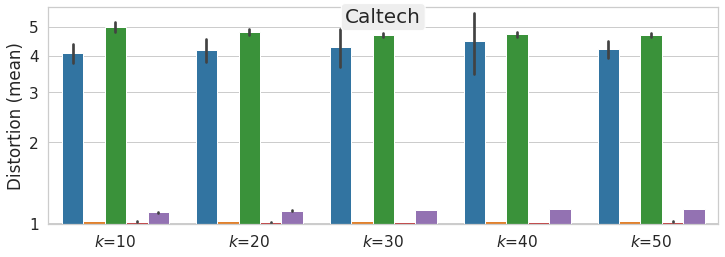

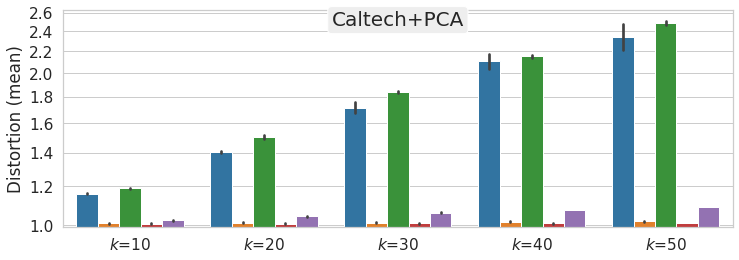

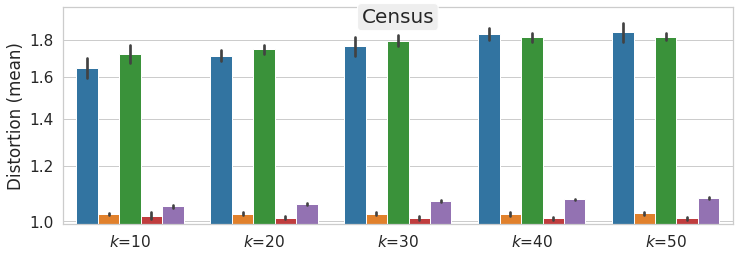

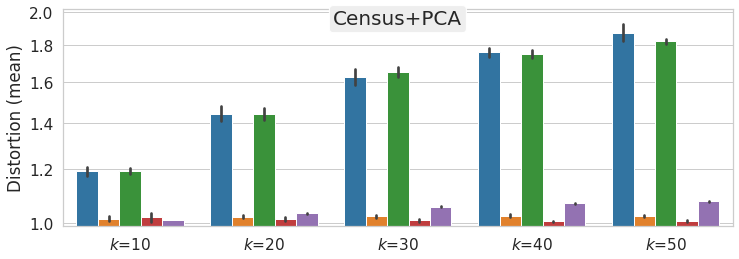

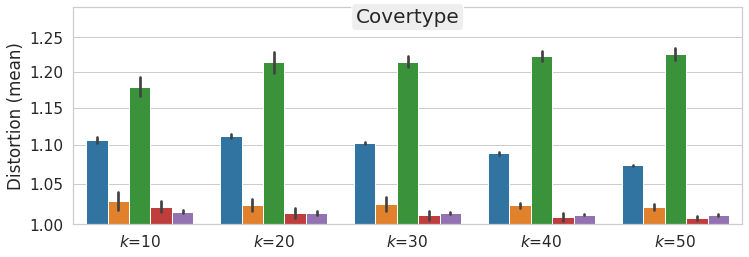

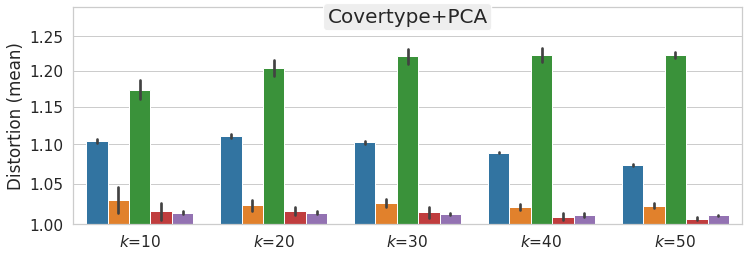

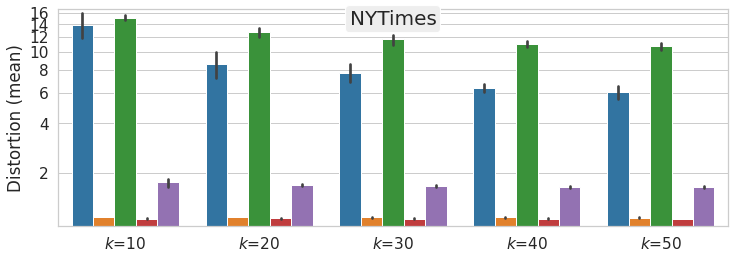

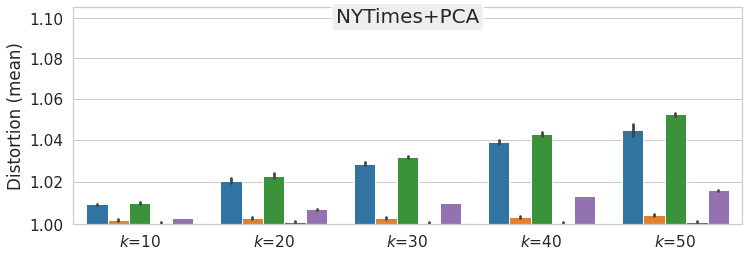

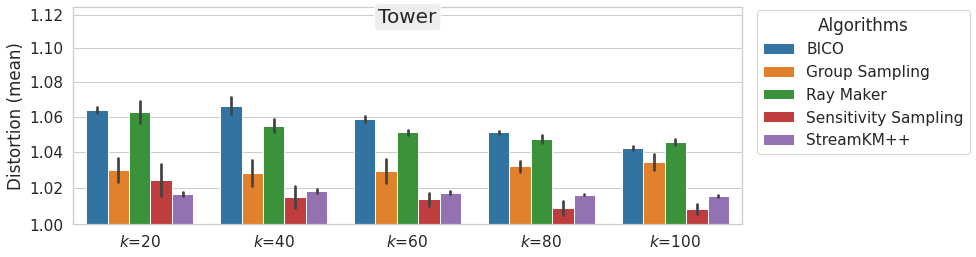

In [7]:
forward = lambda x: x**(1/10)
inverse = lambda x: x**10

with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        if dataset == "Benchmark":
            continue
        is_tower = dataset == "Tower"
        df_filtered = df_raw[df_raw.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm", ci="sd", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.9, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("Distortion (mean)")
        ax.set_xlabel("")
        ax.set_yscale('function', functions=(forward, inverse))
        
        if dataset == "NYTimes":
            ax.set_ylim(bottom=0.9)
        elif dataset in ["NYTimes+PCA", "Tower", "Covertype", "Covertype+PCA"]:
            ax.set_ylim(bottom=1)
        else:
            ax.set_ylim(bottom=0.99)
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if is_tower:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        
        fig.savefig(f"plots/distortions-mean-{dataset}.pdf", bbox_inches="tight")

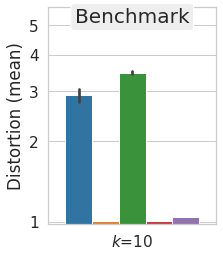

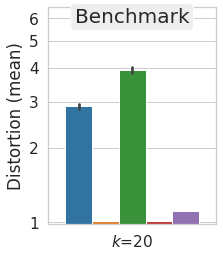

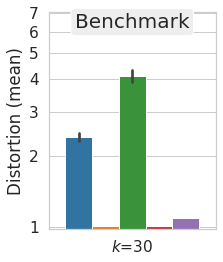

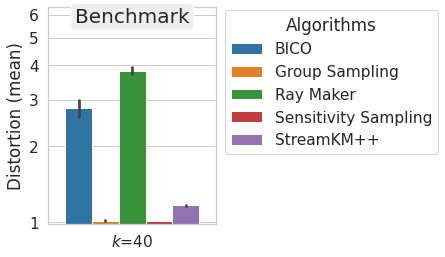

In [8]:
with sns.plotting_context("notebook", font_scale=1.4):
    dataset = "Benchmark"
    for k in [10, 20, 30, 40]:
        df_filtered = df_raw[(df_raw.dataset == dataset) & (df_raw.k == k)]
        fig, ax = plt.subplots(figsize=(3, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm", ci="sd", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.9, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("Distortion (mean)")
        ax.set_xlabel("")
        ax.set_yscale('function', functions=(forward, inverse))
        
        ax.set_ylim(bottom=0.98)
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if k == 40:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        fig.savefig(f"plots/distortions-mean-{dataset}-k{k}.pdf", bbox_inches="tight")

## Coreset Costs Plots

In [9]:
# with sns.plotting_context("notebook", font_scale=1.4):
#     for dataset in df_aggr_costs.dataset.unique():
#         if dataset == "Benchmark":
#             continue
#         is_tower = dataset == "Tower"
#         df_filtered = df_raw[df_raw.dataset == dataset]
#         fig, ax = plt.subplots(figsize=(12, 4))
#         sns.barplot(data=df_filtered, x="k_formatted", y="coreset_cost", hue="algorithm", ci="sd", ax=ax, palette=algorithm_colors)
#         ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.96, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
#         ax.set_ylabel("average coreset cost")
#         ax.set_xlabel("")
#         if is_tower:
#             ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
#         else:
#             ax.get_legend().remove()
#         fig.savefig(f"plots/coreset-costs-{dataset}.pdf", bbox_inches="tight")

In [10]:
# with sns.plotting_context("notebook", font_scale=1.4):
#     dataset = "Benchmark"
#     for k in [10, 20, 30, 40]:
#         df_filtered = df_raw[(df_raw.dataset == dataset) & (df_raw.k == k)]
#         fig, ax = plt.subplots(figsize=(3, 4))
#         sns.barplot(data=df_filtered, x="k_formatted", y="coreset_cost", hue="algorithm", ax=ax, ci="sd", palette=algorithm_colors)
#         ax.set_title(f"{dataset}", fontdict={"size": 20}, x=0.6, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
#         ax.set_ylabel("average coreset cost")
#         ax.set_xlabel("")
#         ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
#         if k == 40:
#             ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
#         else:
#             ax.get_legend().remove()
#         fig.savefig(f"plots/coreset-costs-{dataset}-k{k}.pdf", bbox_inches="tight")

## Real Costs Plots

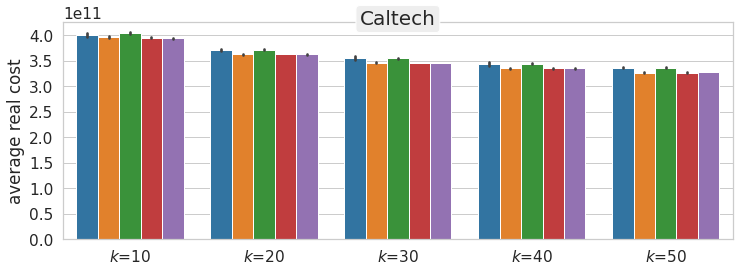

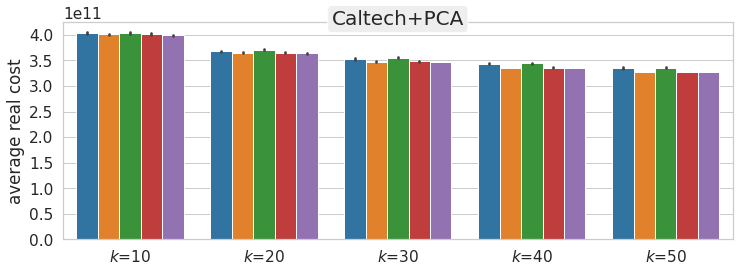

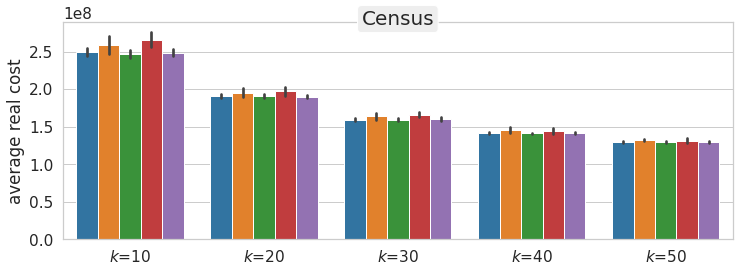

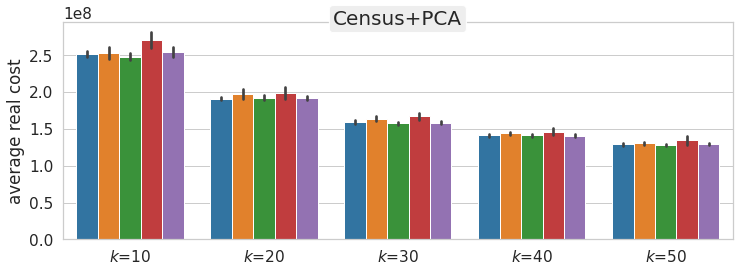

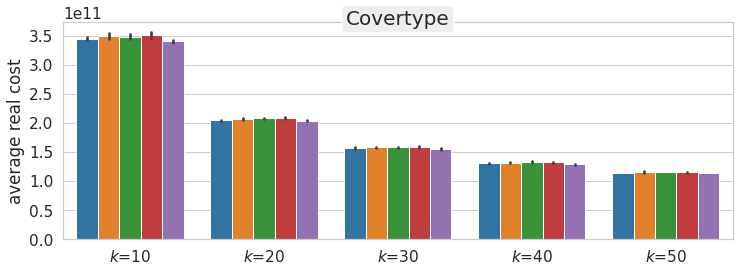

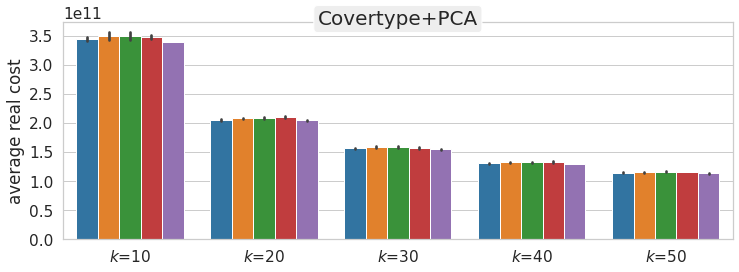

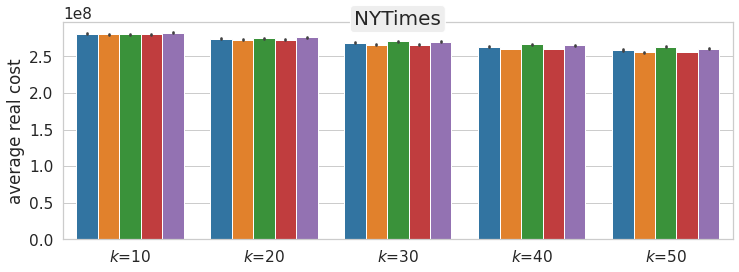

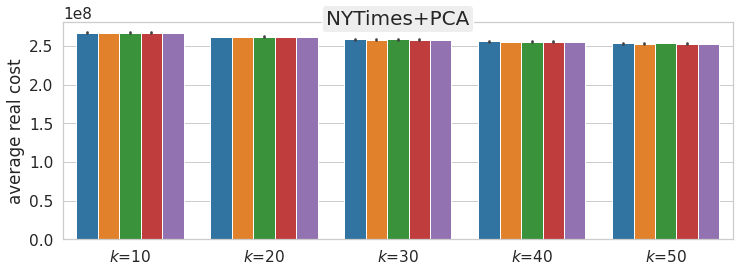

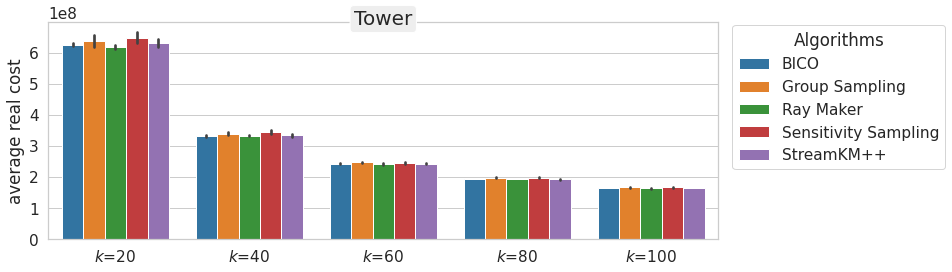

In [11]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        if dataset == "Benchmark":
            continue
        is_tower = dataset == "Tower"
        df_filtered = df_raw[df_raw.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="real_cost", hue="algorithm", ci="sd", ax=ax, palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, y=0.96, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average real cost")
        ax.set_xlabel("")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if is_tower:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        fig.savefig(f"plots/real-costs-{dataset}.pdf", bbox_inches="tight")

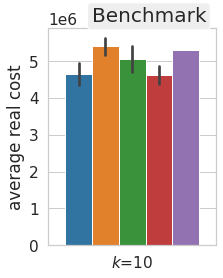

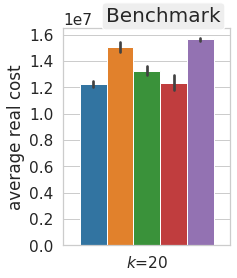

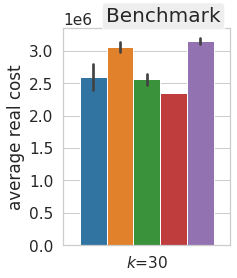

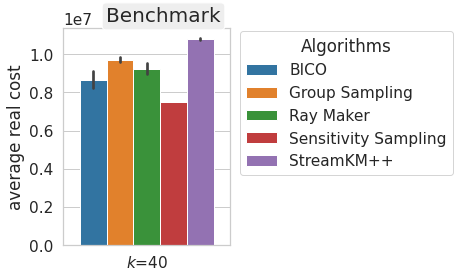

In [12]:
with sns.plotting_context("notebook", font_scale=1.4):
    dataset = "Benchmark"
    for k in [10, 20, 30, 40]:
        df_filtered = df_raw[(df_raw.dataset == dataset) & (df_raw.k == k)]
        fig, ax = plt.subplots(figsize=(3, 4))
        sns.barplot(data=df_filtered, x="k_formatted", y="real_cost", hue="algorithm", ax=ax, ci="sd", palette=algorithm_colors)
        ax.set_title(f"{dataset}", fontdict={"size": 20}, x=0.6, bbox=dict(facecolor="#eee", boxstyle="round,pad=0.2"))
        ax.set_ylabel("average real cost")
        ax.set_xlabel("")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        if k == 40:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        fig.savefig(f"plots/real-costs-{dataset}-k{k}.pdf", bbox_inches="tight")